##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



## Download and explore the dataset

In [3]:
csv_combine = pd.read_csv("../data/snake_species/Csv/train.csv")
csv_test = pd.read_csv("../data/snake_species/Csv/test.csv") 
image_dim = 418

In [4]:
csv_combine.head()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,20e23008100d4e249fd757c11fe059fe,18,Agkistrodon contortrix,1,0.507412,0.546939,0.916220,0.951425
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,0c6d14f33f404013ab116ab09880c523,18,Agkistrodon contortrix,1,0.503115,0.392086,0.835316,0.965363
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,3a31a32de0434653b4a82a30806f7a6d,18,Agkistrodon contortrix,1,0.353031,0.573312,0.652700,0.709286
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,1c5a3b2953c84d698fad8a40db91323e,18,Agkistrodon contortrix,1,0.436368,0.447794,0.918880,0.834457
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e10c99a58c2546dab2c0d998de1f7c1b,18,Agkistrodon contortrix,1,0.512284,0.519067,0.923202,0.631036


This tutorial uses a dataset of about 26120 snake images. The dataset contains sub-directories, one per class:

```

  
/train/
    110  140  165  180  193  220  263  321  352  381  422  448  470  495  544  575  605  628  656  690  71   746  87
    111  155  168  185  195  226  280  323  360  383  424  453  474  497  545  576  609  629  672  691  725  747  88
    113  158  169  186  20   238  284  335  363  384  427  454  477  507  546  578  616  634  674  696  73   751  99
    114  159  175  188  203  25   302  338  364  39   429  457  48   515  560  590  617  65   675  698  738  755
    122  162  177  189  215  255  315  345  368  396  430  462  481  52   562  60   619  651  678  699  740  758
    135  163  18   191  216  26   319  348  373  41   441  464  485  54   57   603  623  652  686  701  741  83
/test/
    110  140  165  180  193  220  263  321  352  381  422  448  470  495  544  575  605  628  656  690  71   746  87
111  155  168  185  195  226  280  323  360  383  424  453  474  497  545  576  609  629  672  691  725  747  88
113  158  169  186  20   238  284  335  363  384  427  454  477  507  546  578  616  634  674  696  73   751  99
114  159  175  188  203  25   302  338  364  39   429  457  48   515  560  590  617  65   675  698  738  755
122  162  177  189  215  255  315  345  368  396  430  462  481  52   562  60   619  651  678  699  740  758
135  163  18   191  216  26   319  348  373  41   441  464  485  54   57   603  623  652  686  701  741  83


```

In [5]:
!ls ../data/snake_species/Csv

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
test.csv  train.csv


In [6]:
class_id = {}
for i,cl in enumerate(csv_combine.class_id.unique()):
    class_id[cl] = i
nclass = i+1 

In [7]:
csv_train = csv_combine
train_size = len(csv_train)
test_size = len(csv_test)

In [8]:
csv_combine.head()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,20e23008100d4e249fd757c11fe059fe,18,Agkistrodon contortrix,1,0.507412,0.546939,0.916220,0.951425
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,0c6d14f33f404013ab116ab09880c523,18,Agkistrodon contortrix,1,0.503115,0.392086,0.835316,0.965363
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,3a31a32de0434653b4a82a30806f7a6d,18,Agkistrodon contortrix,1,0.353031,0.573312,0.652700,0.709286
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,1c5a3b2953c84d698fad8a40db91323e,18,Agkistrodon contortrix,1,0.436368,0.447794,0.918880,0.834457
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e10c99a58c2546dab2c0d998de1f7c1b,18,Agkistrodon contortrix,1,0.512284,0.519067,0.923202,0.631036


In [9]:
csv_train.head()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,20e23008100d4e249fd757c11fe059fe,18,Agkistrodon contortrix,1,0.507412,0.546939,0.916220,0.951425
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,0c6d14f33f404013ab116ab09880c523,18,Agkistrodon contortrix,1,0.503115,0.392086,0.835316,0.965363
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,3a31a32de0434653b4a82a30806f7a6d,18,Agkistrodon contortrix,1,0.353031,0.573312,0.652700,0.709286
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,1c5a3b2953c84d698fad8a40db91323e,18,Agkistrodon contortrix,1,0.436368,0.447794,0.918880,0.834457
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e10c99a58c2546dab2c0d998de1f7c1b,18,Agkistrodon contortrix,1,0.512284,0.519067,0.923202,0.631036


In [10]:
csv_train.tail()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
23811,23811,Xenochrophis piscator,unknown,unknown,Xenochrophis,Colubridae,cbfdd41a35d548b1a5bb7bd17fb25f18,758,Xenochrophis piscator,0,0.480432,0.499014,1.143287,0.761317
23812,23812,Xenochrophis piscator,unknown,unknown,Xenochrophis,Colubridae,8dd9cb33bdf94144b3898f8ac46afc51,758,Xenochrophis piscator,0,0.365966,0.677440,0.628231,0.722022
23813,23813,Xenochrophis piscator,India,Asia,Xenochrophis,Colubridae,1873c9951fab4731ad2c7d49223ef158,758,Xenochrophis piscator,0,0.464893,0.512276,0.809866,0.823931
23814,23814,Xenochrophis piscator,unknown,unknown,Xenochrophis,Colubridae,e092d248cfee42bcaa1e8d6b65a8cc06,758,Xenochrophis piscator,0,0.462215,0.483245,0.920723,0.861148
23815,23815,Xenochrophis piscator,Thailand,Asia,Xenochrophis,Colubridae,d25498a5a28d4aaebe2ff9ecc075b28d,758,Xenochrophis piscator,0,0.430350,0.571703,0.467267,0.476772


In [11]:
df = csv_train
classesdf=df.groupby(['binomial', 'class_id']).size()
pd.set_option('display.max_rows', classesdf.shape[0]+1)
print("Species".ljust(30)+"class_id".ljust(10)+"No Of Images")
print(classesdf)
pd.set_option('display.max_rows', 5)

Species                       class_id  No Of Images
binomial                      class_id
Agkistrodon contortrix        18          180
Agkistrodon piscivorus        20          200
Ahaetulla nasuta              25          199
Ahaetulla prasina             26          200
Arizona elegans               39          181
Aspidites melanocephalus      41          154
Atractus crassicaudatus       48          187
Austrelaps superbus           52          201
Bitis arietans                54          183
Bitis gabonica                57          186
Boa constrictor               60          121
Bogertophis subocularis       65          197
Boiga irregularis             71          196
Boiga kraepelini              73          201
Bothriechis schlegelii        83          208
Bothrops asper                87          202
Bothrops atrox                88          184
Bungarus multicinctus         99          168
Carphophis amoenus            110         175
Carphophis vermis             111 

In [12]:
#print("Species".ljust(60)+"No Of Images")
#for i in csv_train.binomial.unique():
#    print("{} {}".format(i.ljust(63),sum(csv_train.binomial == i)))

In [13]:
!pip install pathlib
import pathlib
data_dir = "../data/snake_species/train/"
data_dir = pathlib.Path(data_dir)

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


After downloading, you should now have a copy of the dataset available. There are 26120 total images:

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

26120


Here are some taiwain cobra (naja atra):

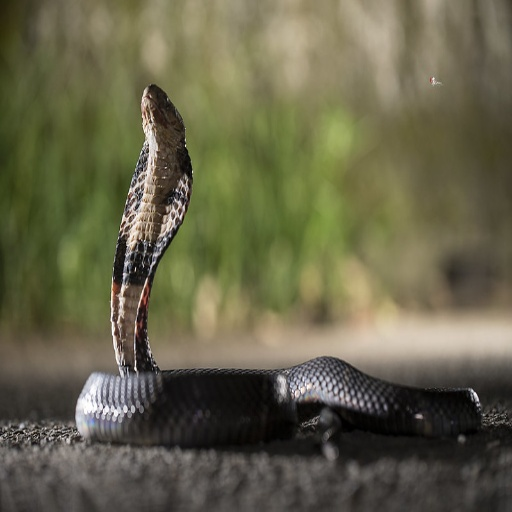

In [15]:
naja_atra = list(data_dir.glob('457/*'))
PIL.Image.open(str(naja_atra[0]))

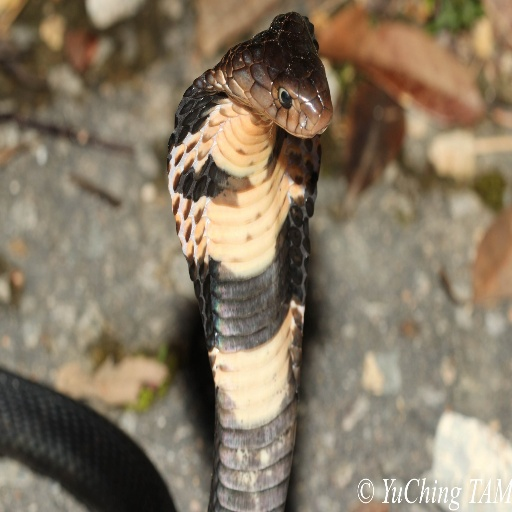

In [16]:
PIL.Image.open(str(naja_atra[1]))

And some king brown, among the longest venomous snakes from australia:

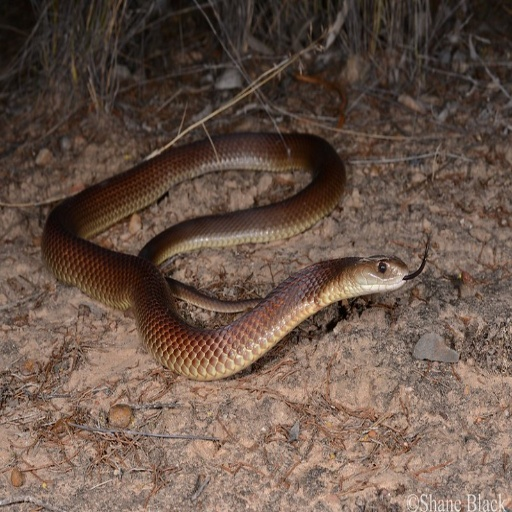

In [17]:
Pseudechis_australis = list(data_dir.glob('576/*'))
PIL.Image.open(str(Pseudechis_australis[0]))

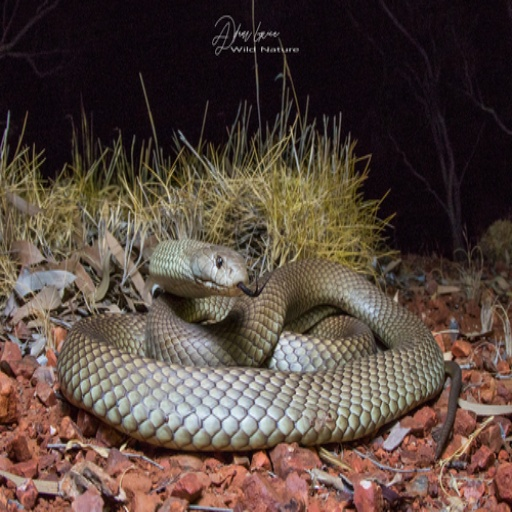

In [18]:
PIL.Image.open(str(Pseudechis_australis[1]))

image size

In [19]:
img = PIL.Image.open(str(Pseudechis_australis[1]))
img.size

(512, 512)

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [20]:
batch_size = 4
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26120 files belonging to 135 classes.
Using 20896 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26120 files belonging to 135 classes.
Using 5224 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [23]:
class_names = train_ds.class_names
print(class_names)

['110', '111', '113', '114', '122', '135', '140', '155', '158', '159', '162', '163', '165', '168', '169', '175', '177', '18', '180', '185', '186', '188', '189', '191', '193', '195', '20', '203', '215', '216', '220', '226', '238', '25', '255', '26', '263', '280', '284', '302', '315', '319', '321', '323', '335', '338', '345', '348', '352', '360', '363', '364', '368', '373', '381', '383', '384', '39', '396', '41', '422', '424', '427', '429', '430', '441', '448', '453', '454', '457', '462', '464', '470', '474', '477', '48', '481', '485', '495', '497', '507', '515', '52', '54', '544', '545', '546', '560', '562', '57', '575', '576', '578', '590', '60', '603', '605', '609', '616', '617', '619', '623', '628', '629', '634', '65', '651', '652', '656', '672', '674', '675', '678', '686', '690', '691', '696', '698', '699', '701', '71', '725', '73', '738', '740', '741', '746', '747', '751', '755', '758', '83', '87', '88', '99']


To obtain the species name

In [24]:
#print(classesdf['class_id'=='110'])
#species_name=classesdf.loc[classesdf['class_id'] == 110]
species = df.loc[df['class_id'] == 110, 'binomial'].unique()
print(species[0])

Carphophis amoenus


## Visualize the data

Here are the first nine images from the training dataset:

InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

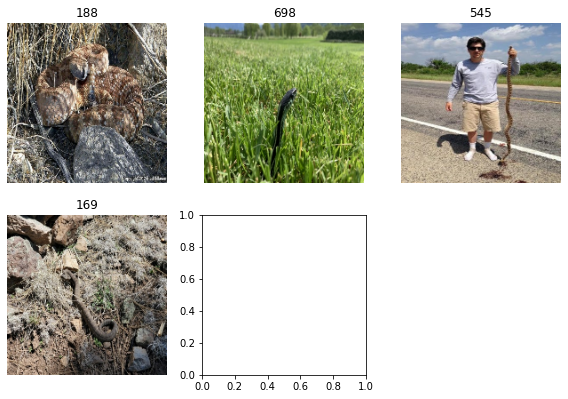

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 180, 180, 3)
(4,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [28]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [30]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [227]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2612/2612 [==============================] - 47s 18ms/step - loss: 4.8343 - accuracy: 0.0133 - val_loss: 4.7292 - val_accuracy: 0.0199
Epoch 2/10
2612/2612 [==============================] - 46s 18ms/step - loss: 4.6353 - accuracy: 0.0296 - val_loss: 4.5882 - val_accuracy: 0.0377
Epoch 3/10
2612/2612 [==============================] - 47s 18ms/step - loss: 4.3592 - accuracy: 0.0636 - val_loss: 4.7425 - val_accuracy: 0.0362
Epoch 4/10
2612/2612 [==============================] - 47s 18ms/step - loss: 3.8784 - accuracy: 0.1435 - val_loss: 5.1952 - val_accuracy: 0.0366
Epoch 5/10
2612/2612 [==============================] - 47s 18ms/step - loss: 3.1842 - accuracy: 0.2740 - val_loss: 6.6435 - val_accuracy: 0.0356
Epoch 6/10
2612/2612 [==============================] - 47s 18ms/step - loss: 2.4819 - accuracy: 0.4242 - val_loss: 8.0169 - val_accuracy: 0.0295
Epoch 7/10
2612/2612 [==============================] - 48s 18ms/step - loss: 1.9477 - accuracy: 0.5371 - val_loss: 9.5249 -

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

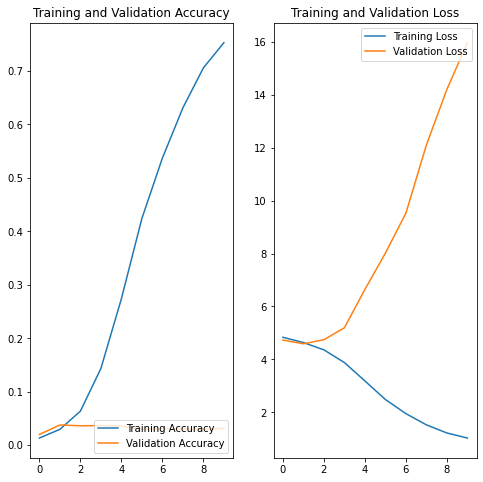

In [228]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

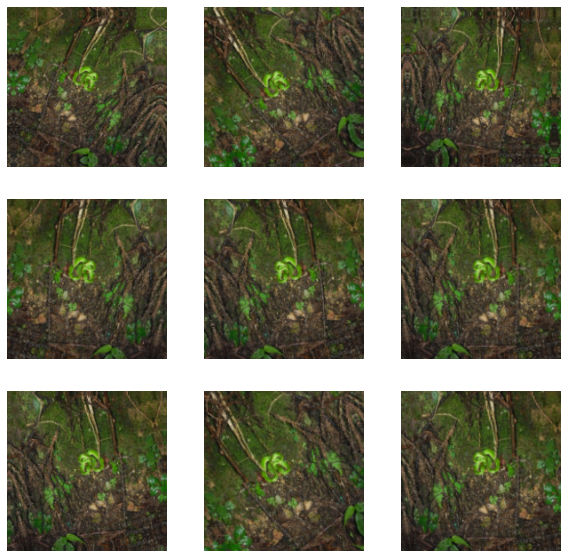

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [36]:
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [41]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
5224/5224 [==============================] - 67s 13ms/step - loss: 4.1704 - accuracy: 0.0839 - val_loss: 4.3944 - val_accuracy: 0.0731
Epoch 2/40
5224/5224 [==============================] - 67s 13ms/step - loss: 4.1529 - accuracy: 0.0884 - val_loss: 4.4390 - val_accuracy: 0.0674
Epoch 3/40
5224/5224 [==============================] - 67s 13ms/step - loss: 4.1433 - accuracy: 0.0877 - val_loss: 4.4002 - val_accuracy: 0.0706
Epoch 4/40
5224/5224 [==============================] - 69s 13ms/step - loss: 4.1353 - accuracy: 0.0896 - val_loss: 4.5036 - val_accuracy: 0.0685
Epoch 5/40
5224/5224 [==============================] - 67s 13ms/step - loss: 4.1221 - accuracy: 0.0874 - val_loss: 4.5675 - val_accuracy: 0.0693
Epoch 6/40
5224/5224 [==============================] - 66s 13ms/step - loss: 4.1022 - accuracy: 0.0937 - val_loss: 4.4421 - val_accuracy: 0.0764
Epoch 7/40
5224/5224 [==============================] - 67s 13ms/step - loss: 4.0949 - accuracy: 0.0974 - val_loss: 4.4369 -

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

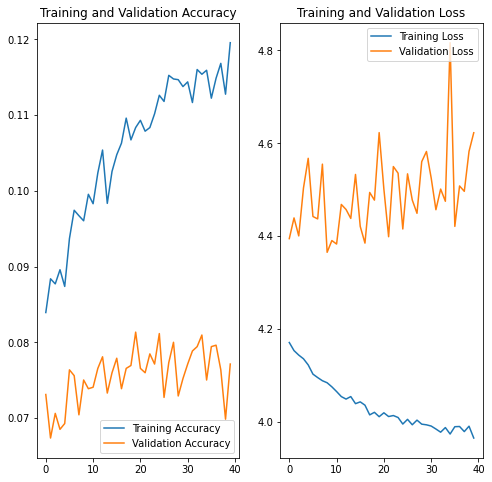

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [44]:
diamondback_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Crotalus_atrox_USFWS.jpg/330px-Crotalus_atrox_USFWS.jpg"
diamondback_path = tf.keras.utils.get_file('DiamondBack', origin=diamondback_url)

img = tf.keras.utils.load_img(
    diamondback_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

49152/39258 [=====================================] - 0s 1us/step
This image most likely belongs to 20 with a 13.68 percent confidence.


## Save the model
Save the model for later use


In [47]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
!ls
model.save('saved_model/serialized_snake_classifier_model_not_tuned.h5')

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
classification_snake_tensorflow_tut.ipynb  snake-classification_kaggle.ipynb
saved_model
